# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240216_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,340.411926,120.340292,349.157329,118.204013,NaN,340.411926,120.340292,NaN,340.411926,120.340292,-1.164580,15328.0,250.896093,84.714567,0.941272,5
1,1,0,1639.166653,140.120752,1635.666768,141.355125,NaN,1639.166653,140.120752,NaN,1639.166653,140.120752,-1.103725,11917.0,216.840858,74.709499,0.938773,5
2,2,0,145.855629,1004.726423,146.614462,1008.123090,NaN,145.855629,1004.726423,NaN,145.855629,1004.726423,0.164961,4814.0,201.308155,59.390954,0.955490,5
3,3,0,1292.550199,1043.498013,1292.203522,1043.742107,0.0,1292.000000,1016.000000,0.537255,1312.000000,1030.000000,-1.370276,3775.0,106.255376,76.044775,0.698429,5
4,4,0,485.429955,1047.691280,485.651212,1047.753802,0.0,411.000000,1028.000000,0.682353,535.000000,1033.000000,-1.551515,3819.0,138.340220,58.020762,0.907799,5
5,0,3,347.832571,122.258648,357.161650,120.169946,NaN,347.832571,122.258648,NaN,347.832571,122.258648,-1.225103,15523.0,250.592311,84.923804,0.940825,5


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1, 2])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         5   340.411926   120.340292    -1.164580
1   1     0         5  1639.166653   140.120752    -1.103725
2   2     0         5   145.855629  1004.726423     0.164961
3   3     0         5  1292.550199  1043.498013    -1.370276
4   4     0         5   485.429955  1047.691280    -1.551515


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,340.411926,120.340292,349.157329,118.204013,NaN,340.411926,120.340292,NaN,340.411926,120.340292,1.164580,15328.0,250.896093,84.714567,0.941272,5
1,1,0,1639.166653,140.120752,1635.666768,141.355125,NaN,1639.166653,140.120752,NaN,1639.166653,140.120752,1.103725,11917.0,216.840858,74.709499,0.938773,5
2,2,0,145.855629,1004.726423,146.614462,1008.123090,NaN,145.855629,1004.726423,NaN,145.855629,1004.726423,0.164961,4814.0,201.308155,59.390954,0.955490,5
5,0,3,347.832571,122.258648,357.161650,120.169946,NaN,347.832571,122.258648,NaN,347.832571,122.258648,-1.225103,15523.0,250.592311,84.923804,0.940825,5
6,1,3,1639.472258,141.118255,1635.817613,142.346027,NaN,1639.472258,141.118255,NaN,1639.472258,141.118255,-1.107454,11805.0,218.848283,73.453686,0.941991,5
7,2,3,134.458541,997.204801,135.685761,1000.993560,NaN,134.458541,997.204801,NaN,134.458541,997.204801,0.448409,5415.0,211.512018,99.637562,0.882094,5
8,3,3,1291.567865,1043.356491,1291.221271,1043.587759,0.0,1292.000000,1016.000000,0.541176,1308.000000,1041.000000,-1.385942,3728.0,105.821329,76.197008,0.693919,5


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
35172,1,107997,868.247117,89.094948,874.472491,91.120978,NaN,868.247117,89.094948,NaN,868.247117,89.094948,1.453389,13439.0,243.443449,81.214330,0.942712,6
35173,2,107997,1574.638003,577.473045,1579.079137,572.106483,NaN,1574.638003,577.473045,NaN,1574.638003,577.473045,-0.657166,10536.0,226.207781,66.452065,0.955877,6
35174,3,107997,1593.904457,938.079401,1587.024479,937.698266,NaN,1593.904457,938.079401,NaN,1593.904457,938.079401,-1.423978,12947.0,194.266432,88.757052,0.889527,6
35175,4,107997,484.777205,1027.107272,485.053344,1027.209904,0.0,406.000000,1014.000000,0.682353,445.000000,1020.000000,1.508715,1939.0,143.241481,47.601192,0.943169,6
35176,5,107997,1593.932315,1066.714885,1592.448852,1066.685887,0.0,1595.000000,1045.000000,0.364706,1610.000000,1076.000000,-1.552640,3339.0,169.930495,31.187126,0.983014,6


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


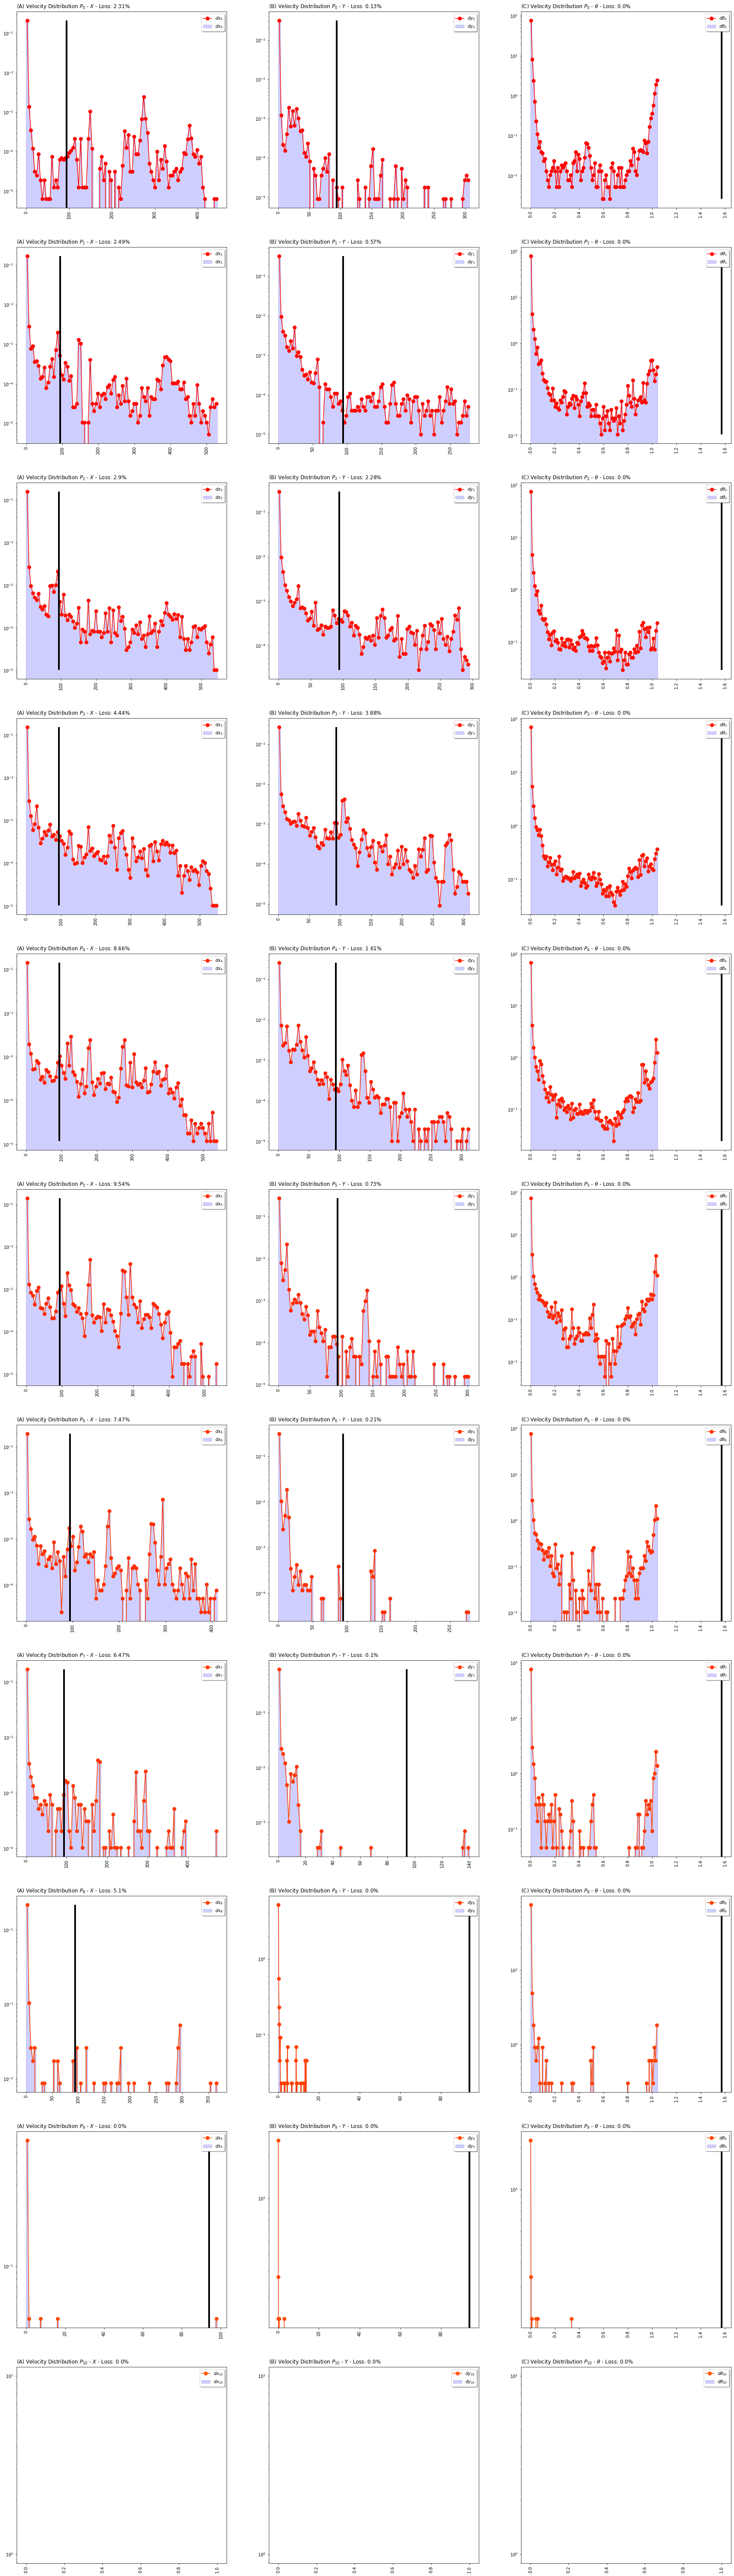

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,10
1,3,1863
2,4,16460
3,5,50733
4,6,71142
5,7,50393
6,8,13936
7,9,2592
8,10,250
9,11,11


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 57.05336407005682 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.002411
1,2,False,True,False,0.002411
2,3,False,False,False,0.812961
3,3,False,True,False,0.034235
4,3,True,False,False,0.028931
5,3,True,True,False,0.022180
6,4,False,False,False,7.495058
7,4,False,True,False,0.155745
8,4,True,False,False,0.190462
9,4,True,True,False,0.095472


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 1.9221520881929448 
	- Angle: 57.05336407005682 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 18.739124952717187%
Final loss data X-axis: 5.327617366452318%
Final loss data Y-axis: 4.481149918043123%
Final loss data Angle : 0.854032698692893%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.000841
1,2,True,True,True,0.003362
2,3,False,False,False,0.021015
3,3,False,False,True,1.268440
4,3,False,True,False,0.074812
5,3,False,True,True,1.755138
6,3,True,False,False,0.010087
7,3,True,False,True,1.131425
8,3,True,True,False,0.242088
9,3,True,True,True,76.757870


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 1.9221520881929448 
	- Angle: 57.05336407005682 



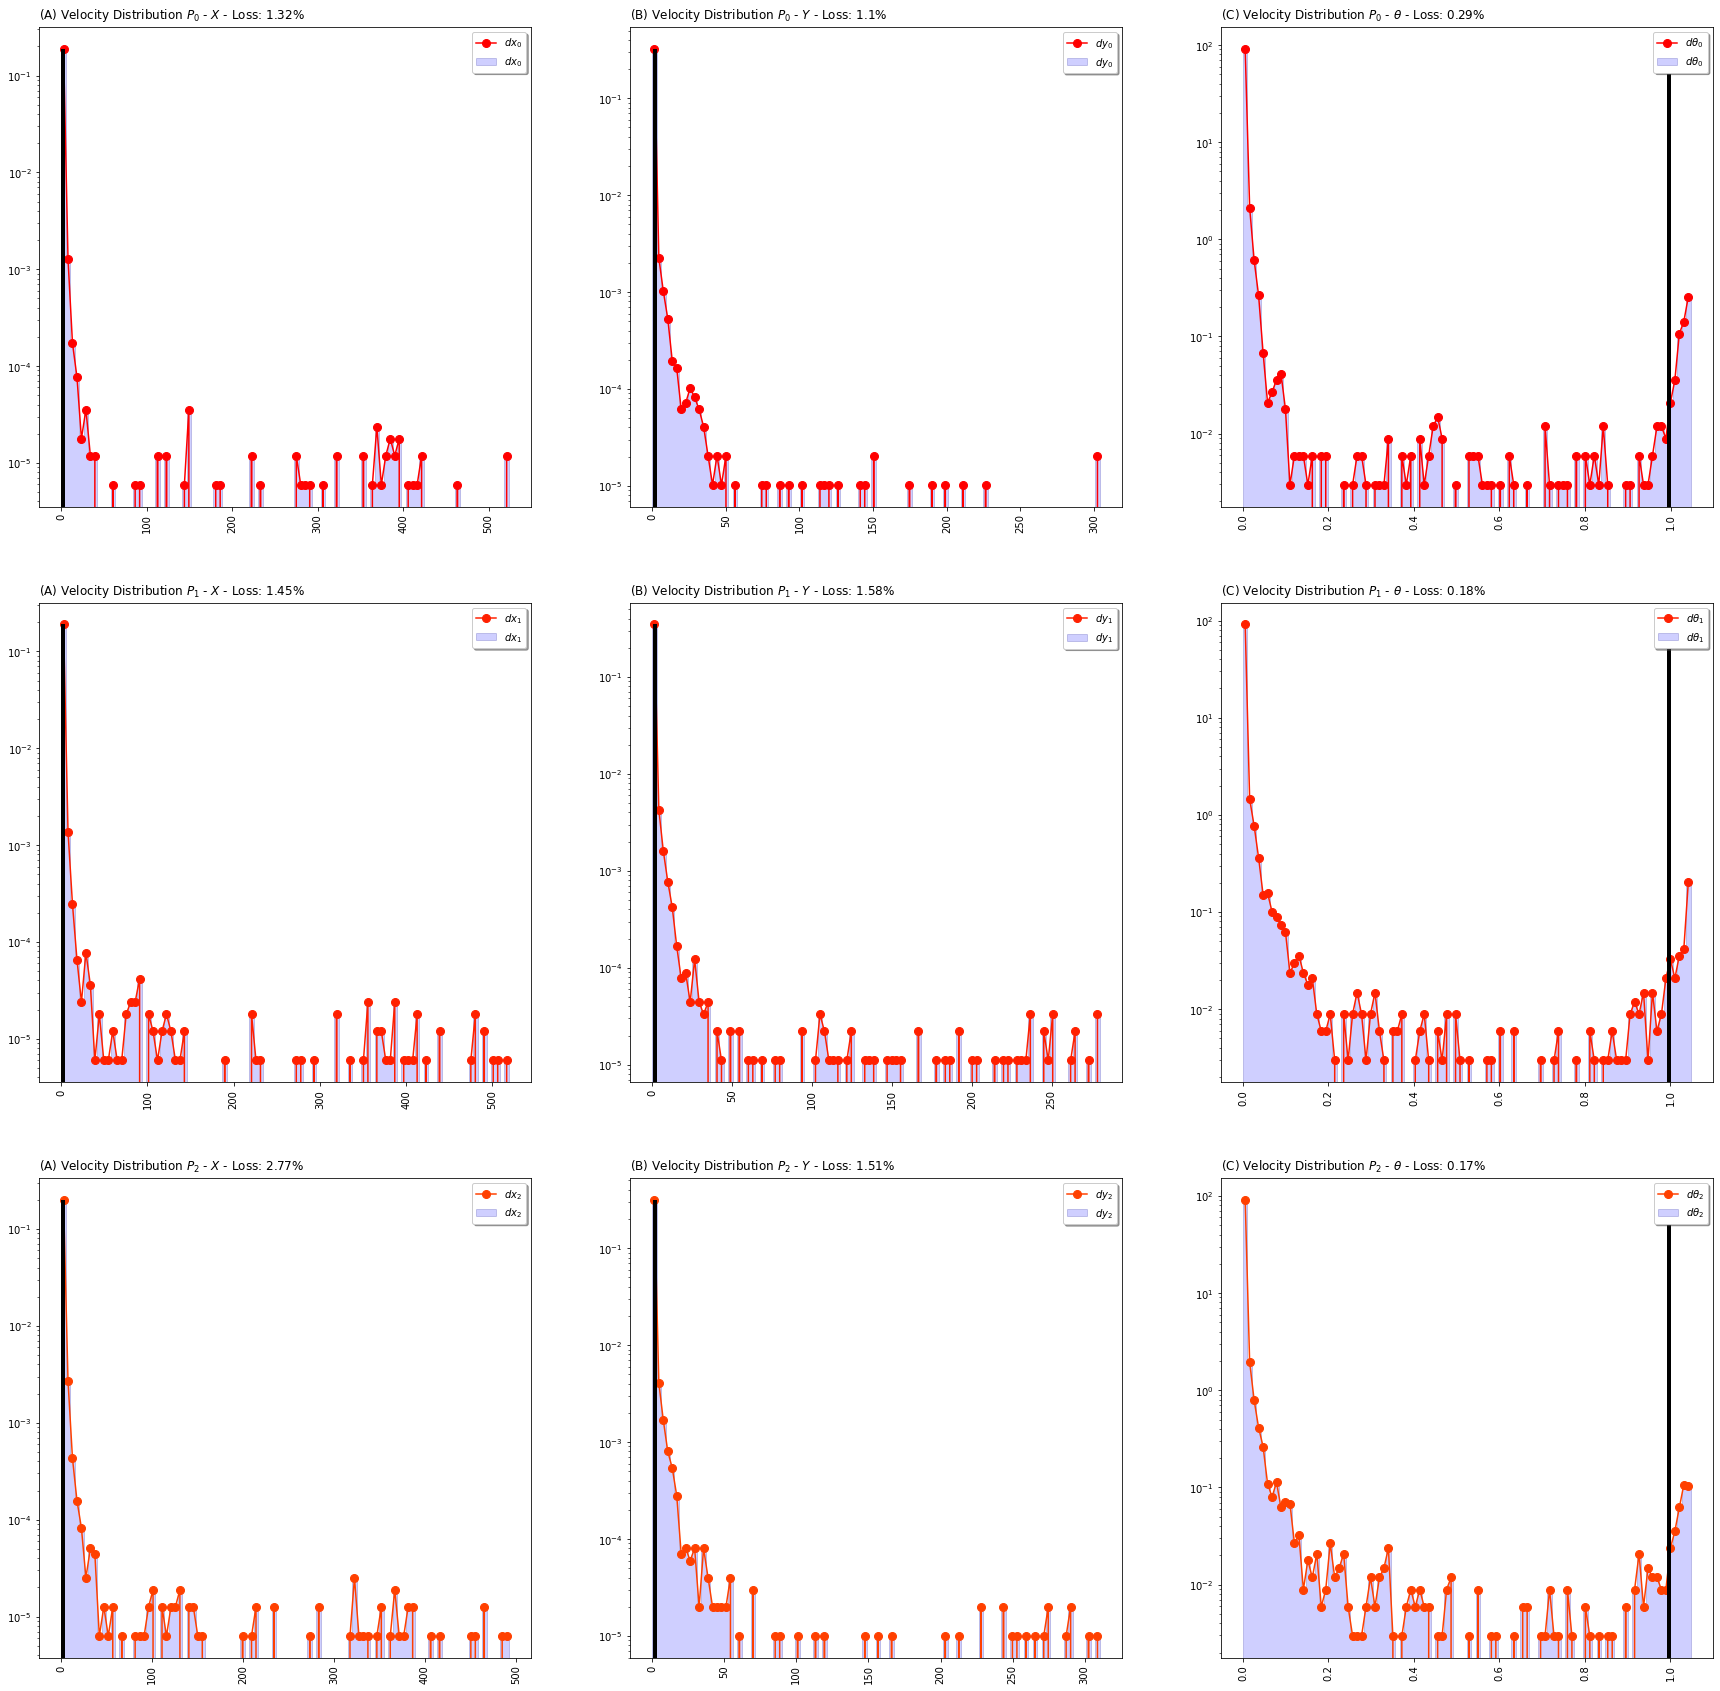

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,340.411926,120.340292,349.157329,118.204013,NaN,340.411926,120.340292,NaN,340.411926,120.340292,1.164580,15328.0,250.896093,84.714567,0.941272,3,NaN,NaN,NaN,NaN,False,False,False
622,1,0,1639.166653,140.120752,1635.666768,141.355125,NaN,1639.166653,140.120752,NaN,1639.166653,140.120752,1.103725,11917.0,216.840858,74.709499,0.938773,3,NaN,NaN,NaN,NaN,False,False,False
1244,2,0,145.855629,1004.726423,146.614462,1008.123090,NaN,145.855629,1004.726423,NaN,145.855629,1004.726423,0.164961,4814.0,201.308155,59.390954,0.955490,3,NaN,NaN,NaN,NaN,False,False,False
1865,0,3,347.832571,122.258648,357.161650,120.169946,NaN,347.832571,122.258648,NaN,347.832571,122.258648,-1.225103,15523.0,250.592311,84.923804,0.940825,3,3.0,2.473548,0.639452,-0.796561,True,False,False
1866,1,3,1639.472258,141.118255,1635.817613,142.346027,NaN,1639.472258,141.118255,NaN,1639.472258,141.118255,-1.107454,11805.0,218.848283,73.453686,0.941991,3,3.0,0.101868,0.332501,-0.737060,False,False,False
1867,2,3,134.458541,997.204801,135.685761,1000.993560,NaN,134.458541,997.204801,NaN,134.458541,997.204801,0.448409,5415.0,211.512018,99.637562,0.882094,3,3.0,-3.799029,-2.507207,0.094483,False,False,False
1868,0,6,369.416784,123.737791,379.615657,121.573066,0.0,423.000000,66.000000,0.619608,417.000000,140.000000,-1.251259,16361.0,251.781858,87.521022,0.937640,3,3.0,7.194738,0.493048,-0.008719,True,False,False
1869,1,6,1638.905250,141.124680,1635.502798,142.222445,NaN,1638.905250,141.124680,NaN,1638.905250,141.124680,-1.091031,12095.0,216.361435,74.333813,0.939130,3,3.0,-0.189002,0.002142,0.005475,False,False,False
1870,2,6,134.267496,998.110835,135.535923,1002.080085,NaN,134.267496,998.110835,NaN,134.267496,998.110835,0.438873,5630.0,212.495098,100.544359,0.880976,3,3.0,-0.063682,0.302011,-0.003179,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240216_1_c.zip'